# Reproduce Paper's Results: SUSY 
## Train and Evaluate
* 5 hidden layered FFNN with 300 neurons, ReLU and droput w/ p = 0,5 on the last two layers
* KAF randomly intialized on the same architecture
* KAF with ELU intialization on the same architecture
* metrics : AUC

* SUSY dataset can be retrieved from https://archive.ics.uci.edu/ml/datasets/SUSY

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from kafnet import Kaf



In [2]:
# Import SUSY and split into train test set as described in the paper

susy = pd.read_csv('SUSY.csv', header=None)

train = susy.values[0:-500000, :].astype(np.float32)
test = susy.values[-500000:, :].astype(np.float32)

train_y = train[:,0].astype(np.int32)
train_X = train[:,1:]
test_y = test[:,0].astype(np.int32)
test_X = test[:,1:]

# Allow batch iteration w/ from_tensor_slices
train = tf.data.Dataset.from_tensor_slices((train_X, train_y))
test = tf.data.Dataset.from_tensor_slices((test_X, test_y))


In [3]:
# Sanity check
for xb, yb in train.batch(4):
  print(xb.shape)
  print(yb)
  break

for xb, yb in test.batch(4):
  print(xb.shape)
  print(yb)
  break

(4, 18)
tf.Tensor([0 1 1 1], shape=(4,), dtype=int32)
(4, 18)
tf.Tensor([0 0 0 1], shape=(4,), dtype=int32)


([array([2441602., 2058398.]), array([270571., 229429.])],
 array([0. , 0.5, 1. ]),
 <a list of 2 Lists of Patches objects>)

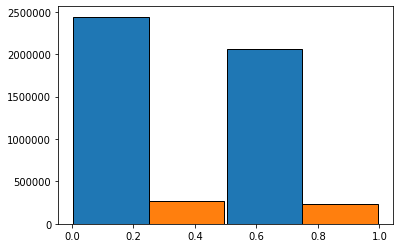

In [4]:
# check balanceness of both train and test somehow if it matches
import matplotlib.pyplot as plt
plt.hist([train_y, test_y], bins=2, rwidth=0.98, ec='black')

In [5]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential

# Build the baseline net
base_net = Sequential([
  Dense(300, activation='relu'),
  Dense(300, activation='relu'),
  Dense(300, activation='relu'),
  Dense(300, activation='relu'),
  Dropout(0.5, seed=42),
  Dense(300, activation='relu'),
  Dropout(0.5, seed=42),
  Dense(1, activation='sigmoid')
])

In [6]:
from tensorflow.keras import losses, optimizers, metrics

base_net.compile(optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy(), 
           metrics = [
               metrics.BinaryAccuracy(),
               metrics.AUC()
           ])

In [7]:
# Train
history = base_net.fit(train.shuffle(1000).batch(64), epochs=3)

Train for 70313 steps
Epoch 1/3
70313/70313 [==============================] - 235s 3ms/step - loss: 0.4366 - binary_accuracy: 0.7993 - auc: 0.8702
Epoch 2/3
70313/70313 [==============================] - 243s 3ms/step - loss: 0.4314 - binary_accuracy: 0.8014 - auc: 0.8733
Epoch 3/3
70313/70313 [==============================] - 242s 3ms/step - loss: 0.4302 - binary_accuracy: 0.8019 - auc: 0.8740


In [8]:
base_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  5700      
_________________________________________________________________
dense_1 (Dense)              multiple                  90300     
_________________________________________________________________
dense_2 (Dense)              multiple                  90300     
_________________________________________________________________
dense_3 (Dense)              multiple                  90300     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  90300     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0

In [9]:
# Evaluate base_kaf
base_net.evaluate(test.batch(32))

15625/15625 [==============================] - 36s 2ms/step - loss: 0.5372 - binary_accuracy: 0.7106 - auc: 0.8765


[0.5372469112300873, 0.710614, 0.87650806]

In [29]:
# Buil the kaf-net with random mix. coefficients initialization
kaf_net_rand = Sequential([
  Dense(300, activation=None, input_dim=18),
  Kaf(20),
  Dense(300, activation=None),
  Kaf(20),  
  Dense(1, activation='sigmoid')
  ])

In [30]:
kaf_net_rand.compile(optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy(), 
           metrics = [
               metrics.BinaryAccuracy(),
               metrics.AUC()
           ])

In [33]:
kaf_net_rand.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 300)               5700      
_________________________________________________________________
kaf_12 (Kaf)                 (None, 300)               6020      
_________________________________________________________________
dense_22 (Dense)             (None, 300)               90300     
_________________________________________________________________
kaf_13 (Kaf)                 (None, 300)               6020      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 301       
Total params: 108,341
Trainable params: 108,301
Non-trainable params: 40
_________________________________________________________________


In [35]:
a = [v for v in kaf_net_rand.trainable_variables if "kaf_12/mix_coeffs" in v.name][0][0][0] # Get the initialized mixing coefficients 
a

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 0.04177585, -0.03045954,  0.0660256 ,  0.04249361,  0.0192998 ,
        0.0099675 , -0.00926417,  0.05316922, -0.03965629, -0.0902501 ,
       -0.03522581,  0.00793103,  0.00685113, -0.05160054,  0.03019127,
       -0.05203108,  0.00775688, -0.0146267 ,  0.02427999,  0.05397806],
      dtype=float32)>

In [36]:
history_kaf_rand = kaf_net_rand.fit(train.shuffle(1000).batch(64), epochs=3)
kaf_net

Train for 70313 steps
Epoch 1/3
70313/70313 [==============================] - 270s 4ms/step - loss: 0.4318 - binary_accuracy: 0.8005 - auc_3: 0.8728
Epoch 2/3
70313/70313 [==============================] - 284s 4ms/step - loss: 0.4285 - binary_accuracy: 0.8021 - auc_3: 0.8749
Epoch 3/3
70313/70313 [==============================] - 287s 4ms/step - loss: 0.4281 - binary_accuracy: 0.8024 - auc_3: 0.8752


NameError: name 'kaf_net_' is not defined

In [44]:
a = [v for v in kaf_net_rand.trainable_variables if "kaf_12/mix_coeffs" in v.name][0][0][0] # Get the learned mixing coefficients 
a

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-0.08786756, -0.14072497,  0.14722724,  0.18386492,  0.08180556,
       -0.04763807, -0.14604159, -0.07475063, -0.08867548, -0.07081905,
        0.01231069,  0.0555472 , -0.00035064, -0.17837678, -0.16623826,
       -0.23908842, -0.06251135,  0.10082988,  0.22444053,  0.32184243],
      dtype=float32)>

In [45]:
# Evaluate 
kaf_net_rand.evaluate(test.batch(32))

15625/15625 [==============================] - 39s 3ms/step - loss: 0.4260 - binary_accuracy: 0.8033 - auc_3: 0.8768


[0.42595165440654753, 0.803338, 0.87684155]

In [47]:
# save so far trained models
base_net.save('baseline_SUSY.h5')
kaf_net_rand.save('kafrand_SUSY.h5')

NotImplementedError: Layers with arguments in `__init__` must override `get_config`.

In [48]:
kaf_net_elu = Sequential([
  Dense(300, activation=None, input_dim=18),
  Kaf(20, ridge='elu'),
  Dense(300, activation=None),
  Kaf(20, ridge='elu'),  
  Dense(1, activation='sigmoid')
])

kaf_net_elu.compile(optimizer=optimizers.Adam(), loss=losses.BinaryCrossentropy(), 
           metrics = [
               metrics.BinaryAccuracy(),
               metrics.AUC()
           ])

In [51]:
kaf_net_elu.summary()
a = [v for v in kaf_net_elu.trainable_variables if "kaf_18/mix_coeffs" in v.name][0][0][0] # Get the initialized mixing coefficients 
a

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 300)               5700      
_________________________________________________________________
kaf_18 (Kaf)                 (None, 300)               6020      
_________________________________________________________________
dense_31 (Dense)             (None, 300)               90300     
_________________________________________________________________
kaf_19 (Kaf)                 (None, 300)               6020      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 301       
Total params: 108,341
Trainable params: 108,301
Non-trainable params: 40
_________________________________________________________________


<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ -1.8350005,   1.9739939,  -0.6543277,  -4.276545 ,  10.725583 ,
       -19.378923 ,  27.587036 , -35.421364 ,  40.252632 , -41.661915 ,
        38.075977 , -29.830292 ,  18.810623 ,  -5.589788 ,  -6.209027 ,
        16.987688 , -21.971584 ,  23.228872 , -16.557596 ,   8.917177 ],
      dtype=float32)>

In [52]:
history_kaf_elu = kaf_net_elu.fit(train.shuffle(1000).batch(64), epochs=3)

Train for 70313 steps
Epoch 1/3
70313/70313 [==============================] - 275s 4ms/step - loss: 0.4323 - binary_accuracy: 0.8002 - auc_6: 0.8724
Epoch 2/3
70313/70313 [==============================] - 279s 4ms/step - loss: 0.4293 - binary_accuracy: 0.8018 - auc_6: 0.8744
Epoch 3/3
70313/70313 [==============================] - 279s 4ms/step - loss: 0.4296 - binary_accuracy: 0.8018 - auc_6: 0.8743


In [53]:
a = [v for v in kaf_net_elu.trainable_variables if "kaf_18/mix_coeffs" in v.name][0][0][0] # Get the learned mixing coefficients 
a

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ -1.4963286 ,   2.0536532 ,  -0.67598057,  -4.3106475 ,
        10.758533  , -19.266426  ,  27.711807  , -35.328903  ,
        40.301613  , -41.6719    ,  38.006454  , -29.944529  ,
        18.670826  ,  -5.7267227 ,  -6.304509  ,  16.960716  ,
       -21.989286  ,  22.922907  , -17.430313  ,   8.110459  ],
      dtype=float32)>

In [54]:
kaf_net_elu.evaluate(test.batch(32))

15625/15625 [==============================] - 36s 2ms/step - loss: 0.4289 - binary_accuracy: 0.8017 - auc_6: 0.8759


[0.4289498586273193, 0.801666, 0.8758888]